In [16]:
import sys

sys.path.append("../")

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

In [19]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [20]:
%config InlineBackend.figure_format = 'retina'

In [21]:
EXPERIMENT_DIR = "lilo_arxiv_v1"
EXPERIMENT_NAME = "library_evaluation_multi"

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
os.makedirs(FIGURES_DIR, exist_ok=True)

In [22]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_dir=EXPERIMENT_DIR,
    experiment_name=EXPERIMENT_NAME,
    experiment_types=["baseline_dreamcoder", "gpt_solver", "gpt_solver_stitch", "gpt_solver_stitch_namer", "gpt_solver_stitch_namer_hybrid_dsl", "gpt_solver_stitch_namer_search"],
    allow_incomplete_results=True,
    compute_likelihoods=True,
    batch_size = "all",
    seeds = [111, 222, 333],
)

Experiment directory: ../lilo_arxiv_v1/outputs/library_evaluation_multi
Available domains: ['re2', 'clevr', 'logo']


### Tasks solved vs. search time

In [23]:
df_search_time = analyzer.get_search_time_results()
df_search_time = df_search_time[df_search_time.split == "test"].reset_index(drop=True)
df_search_time["experiment_type"] = df_search_time["experiment_type"].replace({"gpt_solver": "base_dsl"})
df_search_time

Using enumeration_timeout: 1000
Using enumeration_timeout: 600
Using enumeration_timeout: 1800


,time,n_solved,percent_solved,experiment_type,seed,iteration,split,domain
0,0,0,0.000000,baseline_dreamcoder,111,15,test,re2
1,1,0,0.000000,baseline_dreamcoder,111,15,test,re2
2,2,0,0.000000,baseline_dreamcoder,111,15,test,re2
3,3,0,0.000000,baseline_dreamcoder,111,15,test,re2
4,4,0,0.000000,baseline_dreamcoder,111,15,test,re2
...,...,...,...,...,...,...,...,...
61249,1796,56,0.504505,gpt_solver_stitch_namer_search,333,9,test,logo
61250,1797,56,0.504505,gpt_solver_stitch_namer_search,333,9,test,logo
61251,1798,56,0.504505,gpt_solver_stitch_namer_search,333,9,test,logo
61252,1799,56,0.504505,gpt_solver_stitch_namer_search,333,9,test,logo


In [36]:
assert df_search_time.split.unique() == ["test"]
df_search_time = analyzer.format_dataframe_camera(df_search_time[df_search_time.split == "test"])

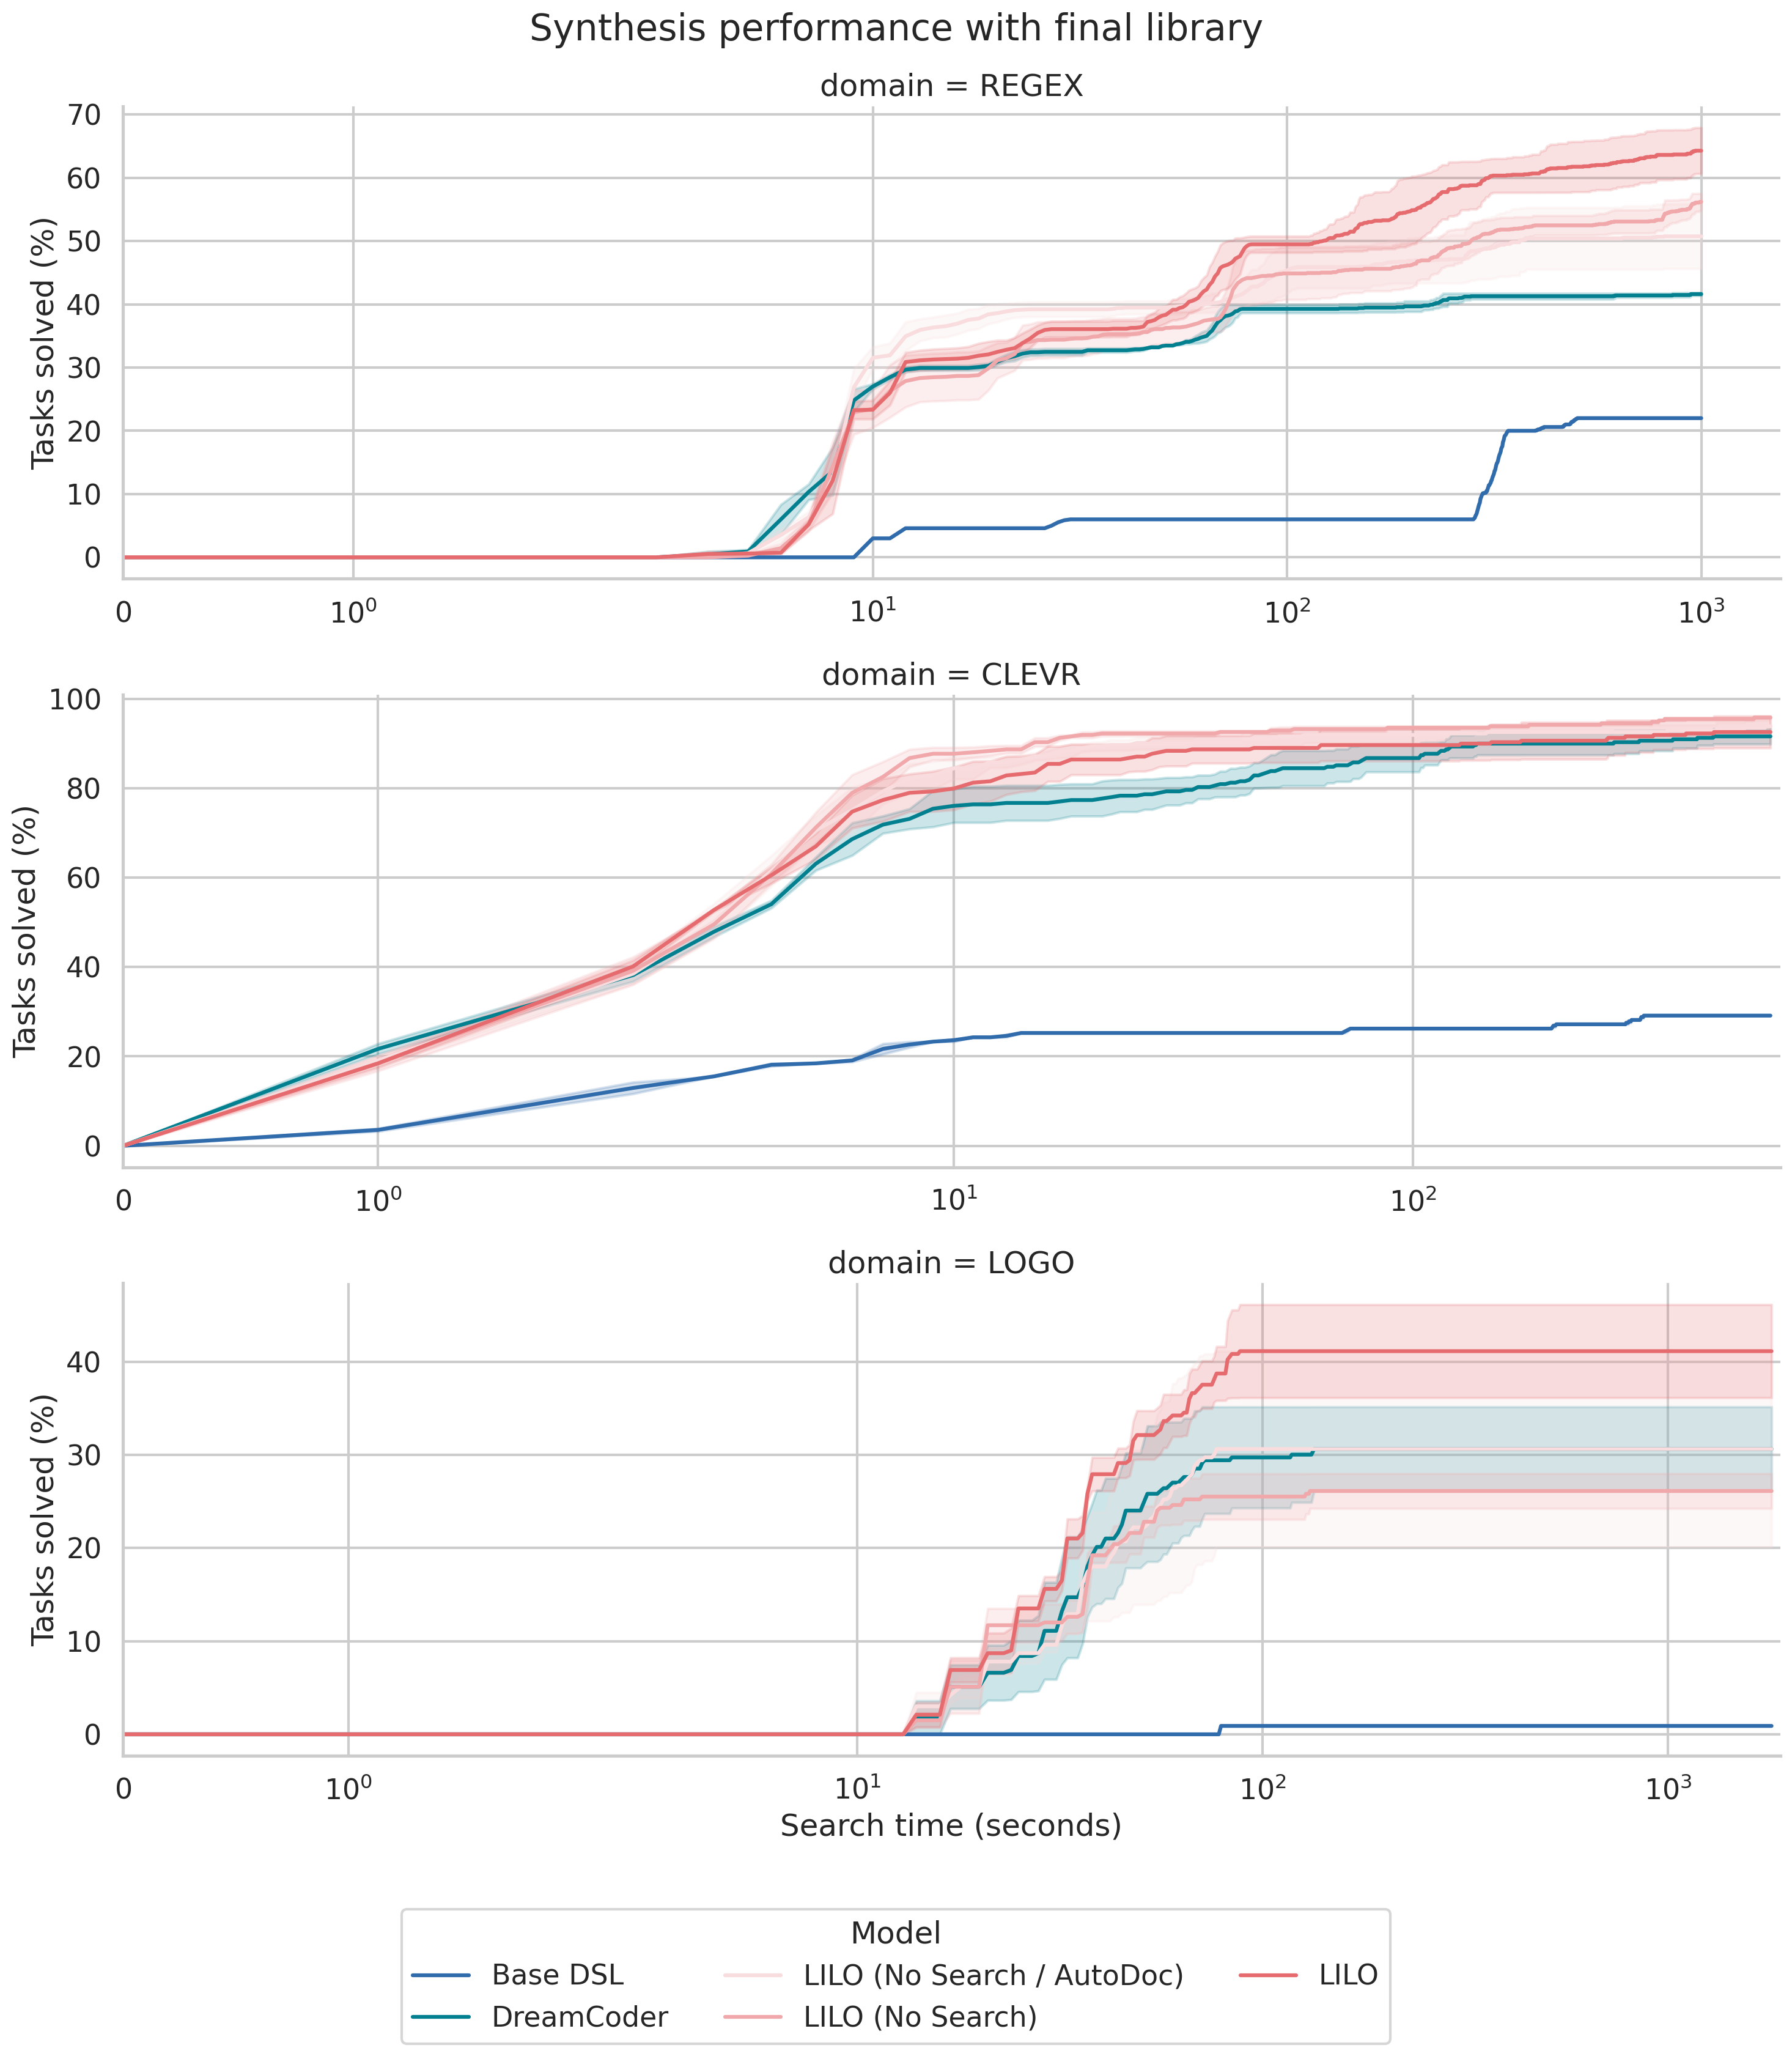

In [37]:
with sns.plotting_context("talk", font_scale=1):
    g = sns.relplot(
        data=df_search_time,
        kind="line",
        row="domain",
        row_order = [d for d in analyzer.DOMAIN_NAMES_CAMERA.values() if d in df_search_time.domain.unique()],
        x="time",
        y=analyzer.COL_NAMES_CAMERA["percent_solved"],
        hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
        errorbar="se",
        # errorbar="sd",
        facet_kws={'sharex': False, 'sharey': False, "legend_out": False},
        palette=analyzer.EXPERIMENT_TYPES_PALETTE,
        aspect=3.0,
    )

    for ax in g.axes.flatten():
        ax.set(xscale='symlog', xlim=(0., None))
    ax.set(xlabel="Search time (seconds)")

    # Move legend to bottom
    sns.move_legend(g, loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.1))

    plt.suptitle(f"Synthesis performance with final library", x=0.5, y=1.015);

    plt.savefig(os.path.join(FIGURES_DIR, "unconditional_synthesis.pdf"), dpi=300, bbox_inches="tight");

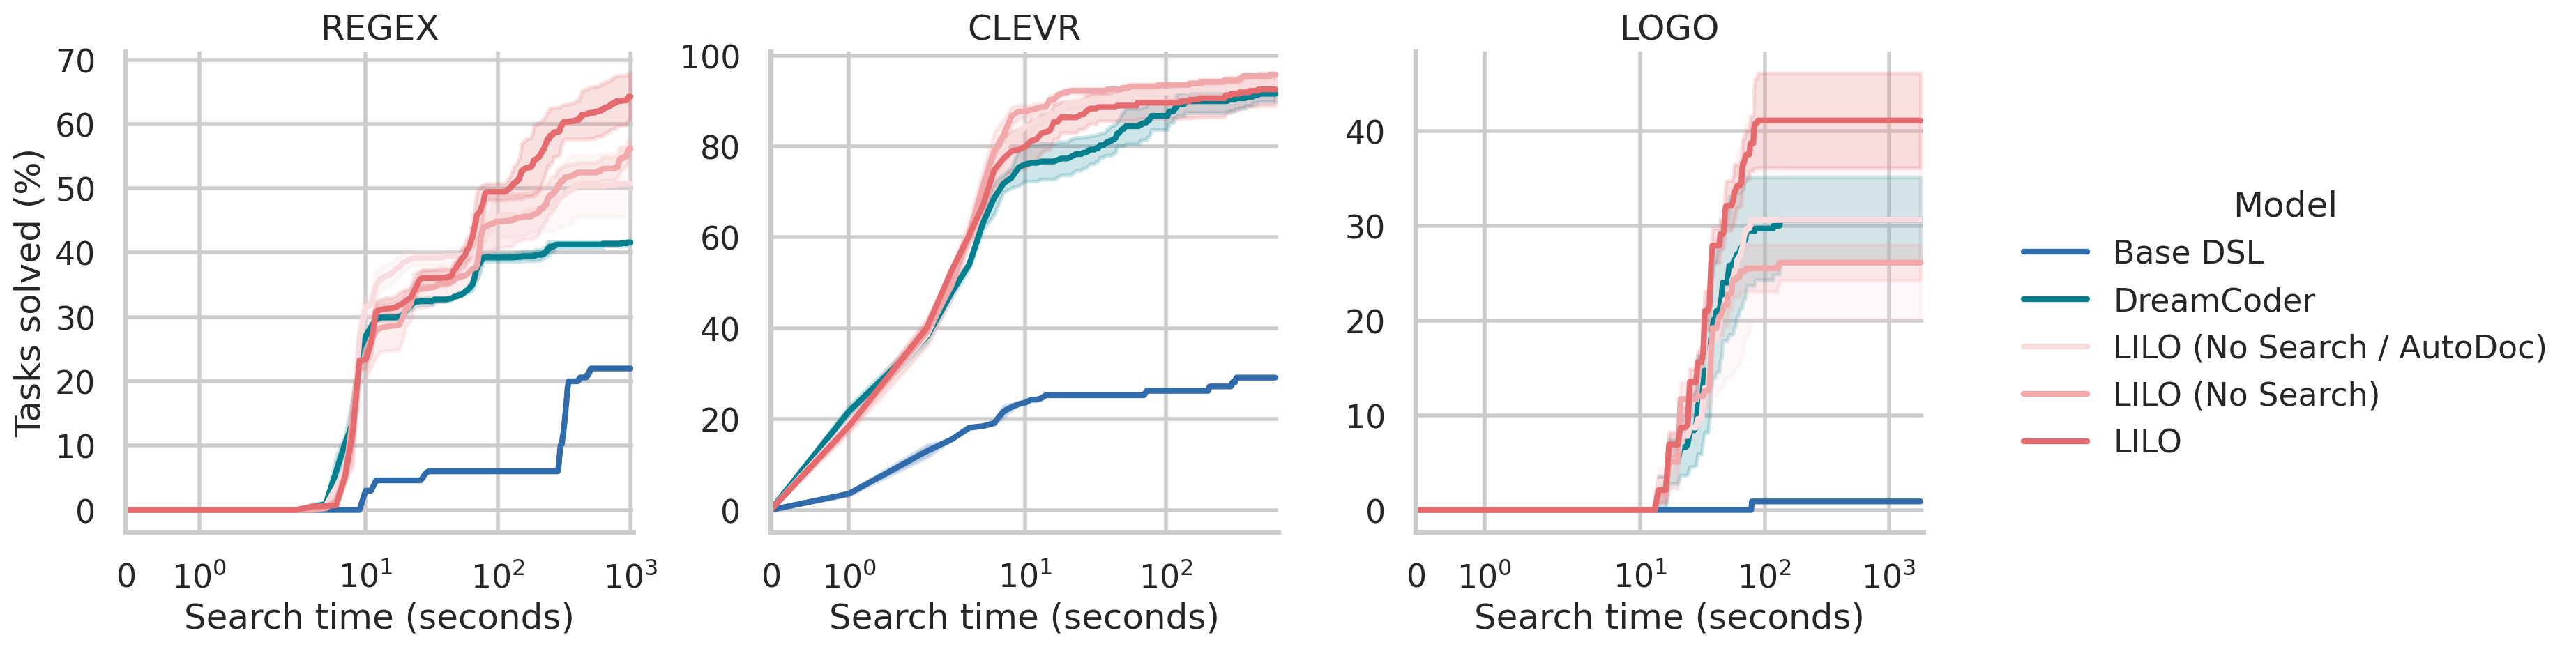

In [45]:
with sns.plotting_context("poster", font_scale=0.75):
    g = sns.relplot(
        data=df_search_time,
        kind="line",
        col="domain",
        col_order = [d for d in analyzer.DOMAIN_NAMES_CAMERA.values() if d in df_search_time.domain.unique()],
        x="time",
        y=analyzer.COL_NAMES_CAMERA["percent_solved"],
        hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
        legend="full",
        errorbar="se",
        facet_kws={'sharex': False, 'sharey': False, 'margin_titles': True},
        palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    )

    for ax in g.axes[0]:
        ax.set(xscale='symlog', xlim=(0., None), xlabel="Search time (seconds)")
        # ax.set(xscale='log', xlim=(1., None), xlabel="Search time (seconds)")
        # ax.set(xlim=(0., None), xlabel="Search time (seconds)")

        # Remove `domain = `
        ax.set_title(ax.title.get_text().split(" = ")[-1])

    # plt.suptitle(f"Synthesis performance with final library", y=1.05);

    plt.savefig(os.path.join(FIGURES_DIR, "unconditional_synthesis_wide.pdf"), dpi=300, bbox_inches="tight");

## Metrics

In [26]:
grouped = analyzer.format_dataframe_camera(df_search_time).groupby([
    "domain",
    analyzer.COL_NAMES_CAMERA["experiment_type"],
    "seed",
], as_index=False)

def _get_final_time(group):
    final_time = group["time"].max().item()
    return group[group["time"] == final_time]

df_results_test = grouped.apply(_get_final_time).reset_index(drop=True)
df_results_test

,time,n_solved,Tasks solved (%),Model,seed,iteration,split,domain
0,1000,110,22.000000,Base DSL,111,15,test,REGEX
1,1000,110,22.000000,Base DSL,222,15,test,REGEX
2,1000,110,22.000000,Base DSL,333,15,test,REGEX
3,1000,210,42.000000,DreamCoder,111,15,test,REGEX
4,1000,206,41.200000,DreamCoder,222,15,test,REGEX
5,1000,208,41.600000,DreamCoder,333,15,test,REGEX
6,1000,236,47.200000,LILO (No Search / AutoDoc),111,15,test,REGEX
7,1000,221,44.200000,LILO (No Search / AutoDoc),222,15,test,REGEX
8,1000,304,60.800000,LILO (No Search / AutoDoc),333,15,test,REGEX
9,1000,288,57.600000,LILO (No Search),111,15,test,REGEX


In [27]:
df_metrics_test = df_results_test.groupby([
    "domain",
    analyzer.COL_NAMES_CAMERA["experiment_type"],
]) \
[[
    analyzer.COL_NAMES_CAMERA["percent_solved"]
]] \
.agg(["mean", "max", "std"])

df_metrics_test = df_metrics_test.reindex(list(analyzer.DOMAIN_NAMES_CAMERA.values()), level=0)
df_metrics_test

Tasks solved (%)                      
                                              mean        max        std
domain Model                                                            
REGEX  Base DSL                          22.000000  22.000000   0.000000
       DreamCoder                        41.600000  42.000000   0.400000
       LILO (No Search / AutoDoc)        50.733333  60.800000   8.846091
       LILO (No Search)                  56.200000  57.600000   2.253886
       LILO                              64.266667  71.400000   6.312950
CLEVR  Base DSL                          29.126214  29.126214   0.000000
       DreamCoder                        91.585761  94.174757   2.966068
       LILO (No Search / AutoDoc)        93.851133  95.145631   2.242137
       LILO (No Search)                  95.792880  96.116505   0.560534
       LILO                              92.556634  96.116505   6.165877
LOGO   Base DSL                           0.900901   0.900901   0.000000
       DreamCoder                        30.630631  36.036036   7.853872
       LILO (No Search / AutoDoc)        30.630631  51.351351  18.219593
       LILO (No Search)                  26.126126  28.828829   3.248244
       LILO                              41.141141  50.450450   8.656778

In [28]:
# Reorder column levels
df_metrics_test_final = df_metrics_test.reset_index().pivot(index="Model", columns="domain")
df_metrics_test_final= df_metrics_test_final.reorder_levels(order=[0, 2, 1], axis="columns")

# Reorder columns
multiindex = df_metrics_test_final.columns
multiindex = multiindex.reindex(list(analyzer.DOMAIN_NAMES_CAMERA.values()), level=1)[0]
multiindex = multiindex.reindex(["max", "mean", "std"], level=2)[0]

df_metrics_test_final = df_metrics_test_final.reindex(columns=multiindex)
df_metrics_test_final.columns.names = [None, None, None]

# Reorder rows
experiment_types = [x for x in analyzer.EXPERIMENT_TYPES_CAMERA.values() if x in df_metrics_test_final.index]
df_metrics_test_final = df_metrics_test_final.reindex(experiment_types)

# Remove 'Model'
df_metrics_test_final.index.name = None

# Round numbers
df_metrics_test_final = df_metrics_test_final.round(2)

# Output to LaTeX
df_metrics_test_final.to_latex("unconditional_synthesis_results.tex")

df_metrics_test_final

Tasks solved (%)                                   \
                                      REGEX               CLEVR                
                                        max   mean   std    max   mean   std   
Base DSL                               22.0  22.00  0.00  29.13  29.13  0.00   
DreamCoder                             42.0  41.60  0.40  94.17  91.59  2.97   
LILO (No Search / AutoDoc)             60.8  50.73  8.85  95.15  93.85  2.24   
LILO (No Search)                       57.6  56.20  2.25  96.12  95.79  0.56   
LILO                                   71.4  64.27  6.31  96.12  92.56  6.17   

                                                 
                             LOGO                
                              max   mean    std  
Base DSL                     0.90   0.90   0.00  
DreamCoder                  36.04  30.63   7.85  
LILO (No Search / AutoDoc)  51.35  30.63  18.22  
LILO (No Search)            28.83  26.13   3.25  
LILO                        50.45  41.14   8.66

In [ ]:
# NOTE WEIRD BUG WHERE MAX COLUMN IS TRUNCATED